In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import sklearn
from sklearn import preprocessing
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [ ]:
# load data
data_2014 = pd.read_csv('2014_Financial_Data.csv')
data_2015 = pd.read_csv('2015_Financial_Data.csv')
data_2016 = pd.read_csv('2016_Financial_Data.csv')
data_2017 = pd.read_csv('2017_Financial_Data.csv')
data_2018 = pd.read_csv('2018_Financial_Data.csv')

In [ ]:
# rename the first column
data_2014.rename(columns={'Unnamed: 0': 'Company'}, inplace=True)
data_2015.rename(columns={'Unnamed: 0': 'Company'}, inplace=True)
data_2016.rename(columns={'Unnamed: 0': 'Company'}, inplace=True)
data_2017.rename(columns={'Unnamed: 0': 'Company'}, inplace=True)
data_2018.rename(columns={'Unnamed: 0': 'Company'}, inplace=True)

In [ ]:
# drop the PRICE VAR column since we will do classification instead of regression
data_2014.drop(columns=['2015 PRICE VAR [%]'], inplace=True)
data_2015.drop(columns=['2016 PRICE VAR [%]'], inplace=True)
data_2016.drop(columns=['2017 PRICE VAR [%]'], inplace=True)
data_2017.drop(columns=['2018 PRICE VAR [%]'], inplace=True)
data_2018.drop(columns=['2019 PRICE VAR [%]'], inplace=True)

In [ ]:
# concate dataframes from 2014 - 2018
data = pd.concat([data_2014,data_2015,data_2016,data_2017,data_2018],ignore_index=True)
data.drop(columns=['Company'], inplace=True)

In [ ]:
# look at data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22077 entries, 0 to 22076
Columns: 223 entries, Revenue to Class
dtypes: float64(221), int64(1), object(1)
memory usage: 37.6+ MB


In [ ]:
data.head()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,...,3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,Class
0,7.440100e+10,-0.0713,3.903000e+10,3.537100e+10,0.000000e+00,2.146100e+10,2.146100e+10,1.391000e+10,7.090000e+08,1.449400e+10,...,0.0751,-0.0187,-0.0217,0.0359,0.0316,0.1228,0.0000,-0.1746,Consumer Defensive,0
1,3.734148e+09,1.1737,2.805625e+09,9.285226e+08,1.083303e+08,3.441414e+08,7.939267e+08,1.345959e+08,1.214869e+07,1.753823e+08,...,NaN,NaN,NaN,NaN,NaN,NaN,1.6484,1.7313,Consumer Defensive,0
2,9.837500e+10,0.0182,7.813800e+10,2.023700e+10,0.000000e+00,1.519600e+10,1.751200e+10,2.725000e+09,4.430000e+08,2.270000e+09,...,0.1633,0.0618,0.0981,0.1886,0.3268,0.2738,0.0000,0.0234,Consumer Defensive,1
3,2.552641e+10,0.0053,1.820268e+10,7.323734e+09,0.000000e+00,6.561162e+09,6.586482e+09,7.372520e+08,4.245910e+08,2.502180e+08,...,0.0000,0.0211,-0.0510,-0.0189,0.1963,-0.0458,0.0000,-0.0060,Consumer Defensive,1
4,1.790960e+10,0.0076,1.153980e+10,6.369800e+09,0.000000e+00,3.474300e+09,3.412400e+09,2.957400e+09,3.024000e+08,2.707700e+09,...,0.1144,0.0257,0.0090,0.0215,0.0274,0.1025,0.0000,-0.0220,Consumer Defensive,1


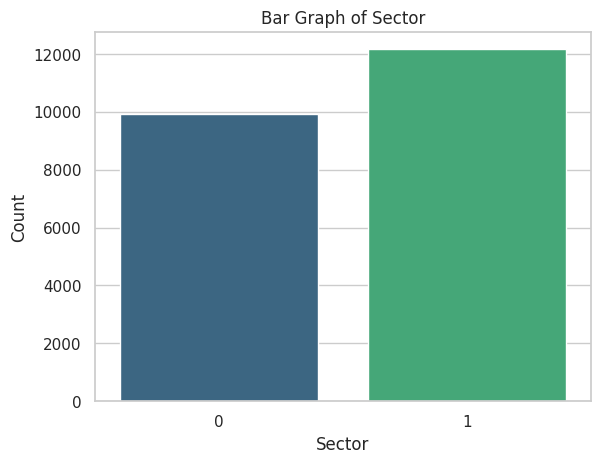

In [ ]:
# visualize class distribution
sns.set(style="whitegrid")
sns.countplot(data=data, x='Class', palette='viridis')
plt.title('Bar Graph of Sector')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.show()

Basic Feature Engineering

In [ ]:
# print correlation
numerical = [col for col in data.columns if data[col].dtype!='O']
correlation_matrix = data[numerical].corr()
print(correlation_matrix)

                              Revenue  Revenue Growth  Cost of Revenue  \
Revenue                      1.000000       -0.002762         0.978873   
Revenue Growth              -0.002762        1.000000        -0.002322   
Cost of Revenue              0.978873       -0.002322         1.000000   
Gross Profit                 0.803631       -0.002995         0.664948   
R&D Expenses                 0.342421       -0.001327         0.277569   
...                               ...             ...              ...   
Book Value per Share Growth -0.001580        0.000250        -0.001930   
Debt Growth                 -0.004237        0.000937        -0.003759   
R&D Expense Growth          -0.005282        0.000063        -0.004424   
SG&A Expenses Growth        -0.005087        0.000279        -0.004152   
Class                        0.021706       -0.006344         0.017588   

                             Gross Profit  R&D Expenses  SG&A Expense  \
Revenue                          0.803

In [ ]:
upper_corr = np.triu(correlation_matrix)
upper_corr = pd.DataFrame(upper_corr)
upper_corr

,0,1,2,3,4,5,6,7,8,9,...,212,213,214,215,216,217,218,219,220,221
0,1.0,-0.002762,0.978873,0.803631,0.342421,0.581138,0.810497,0.664840,0.626497,0.667234,...,0.066398,0.049766,-0.002403,-0.008144,-0.005637,-0.001580,-0.004237,-0.005282,-0.005087,0.021706
1,0.0,1.000000,-0.002322,-0.002995,-0.001327,-0.002722,-0.002880,-0.002662,-0.002699,-0.002629,...,-0.000076,-0.000826,0.006813,0.002319,0.000098,0.000250,0.000937,0.000063,0.000279,-0.006344
2,0.0,0.000000,1.000000,0.664948,0.277569,0.438070,0.610563,0.465968,0.567145,0.487396,...,0.052653,0.039019,-0.003491,-0.006340,-0.004605,-0.001930,-0.003759,-0.004424,-0.004152,0.017588
3,0.0,0.000000,0.000000,1.000000,0.460968,0.847257,0.956302,0.845929,0.638521,0.816913,...,0.075368,0.057078,-0.002513,-0.009369,-0.006254,-0.000436,-0.003987,-0.005491,-0.005503,0.030948
4,0.0,0.000000,0.000000,0.000000,1.000000,0.284509,0.389132,0.397971,0.180715,0.474353,...,0.030517,0.022071,-0.001681,-0.002503,-0.002864,-0.000180,-0.002030,-0.000822,-0.002117,0.034650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.008232,-0.002085,0.002437,-0.016437
218,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.001347,0.025673,0.005874
219,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.006321,-0.001809
220,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.013750


In [ ]:
to_drop = []

# Iterate through the upper traingular correlation matrix
for i in range(len(correlation_matrix.columns)-1):
    for j in range(i+1):
        item = upper_corr.iloc[j:(j+1), (i+1):(i+2)]
        col = item.columns

        if abs(item.values) >= 0.8: # threshold
            to_drop.append(col.values[0])

# Drop
data = data.drop(data.columns[to_drop], axis = 1)

In [ ]:
# standardize numeric features
scaler = StandardScaler()
data[data.columns[:-2]] = scaler.fit_transform(data[data.columns[:-2]])

In [ ]:
# one-hot encode sector
data = pd.get_dummies(data, columns = ["Sector"])

In [ ]:
missing_data = data.isnull().sum()
print(missing_data)

Revenue               1171
Revenue Growth        2088
Cost of Revenue       1771
Gross Profit          1207
R&D Expenses          2138
                      ... 
Sector_Healthcare        0
Sector_Industrials       0
Sector_Real Estate       0
Sector_Technology        0
Sector_Utilities         0
Length: 233, dtype: int64


In [ ]:
observations = data.shape[0]
threshold = observations * 0.5
large_proportion_missing = missing_data[missing_data > threshold]
large_proportion_missing

operatingCycle         22058
cashConversionCycle    22058
dtype: int64

In [ ]:
# drop columns that have over 50% of missing data
data.drop(columns=large_proportion_missing.index, inplace=True)

In [ ]:
# use knn to impute the rest of missing columns
imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

In [ ]:
# check missing data again
data.isnull().sum()

Revenue               1171
Revenue Growth        2088
R&D Expenses          2138
Interest Expense      1719
Income Tax Expense    1588
                      ... 
Sector_Healthcare        0
Sector_Industrials       0
Sector_Real Estate       0
Sector_Technology        0
Sector_Utilities         0
Length: 117, dtype: int64

In [ ]:
# see which features are categorical

numerical = [col for col in data.columns if data[col].dtype!='O']
categorical = [col for col in data.columns if data[col].dtype=='O']
print(f'Numerical cols:{numerical}')
print(f'Categorical cols:{categorical}')

Numerical cols:['age', 'hypertension', 'heart_disease', 'ever_married', 'avg_glucose_level', 'bmi', 'stroke', 'is_bmi_missing']
Categorical cols:['gender', 'work_type', 'Residence_type', 'smoking_status']


In [ ]:
data[categorical].nunique()

gender            3
work_type         5
Residence_type    2
smoking_status    4
dtype: int64

In [ ]:
print('Gender:\n', data['gender'].value_counts(), "\n")
print('Work Type:\n', data['work_type'].value_counts(), "\n")
print('Residence Type:\n', data['Residence_type'].value_counts(), "\n")
print('Smoking Status:\n', data['smoking_status'].value_counts(), "\n")

Gender:
 Female    2994
Male      2115
Other        1
Name: gender, dtype: int64 

Work Type:
 Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64 

Residence Type:
 Urban    2596
Rural    2514
Name: Residence_type, dtype: int64 

Smoking Status:
 never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64 



In [ ]:
# for lable encoding
print("Smoking Status: ", data['smoking_status'].unique())

Smoking Status:  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [ ]:
# manual label encoding (creating mapping dictionaries)
mapping_smoke = {'never smoked': 0, 'formerly smoked': 1, 'Unknown': 2,'smokes':3}

In [ ]:
# label encode
data['smoking_status'] = data['smoking_status'].map(mapping_smoke)

In [ ]:
# one hot encoding
data = pd.get_dummies(data, columns = ['gender',
                                       "work_type",
                                       "Residence_type"])

In [ ]:
data.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,smoking_status,stroke,is_bmi_missing,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban
0,67.0,0,1,1,228.69,36.6,1,1,0,0,1,0,0,0,1,0,0,0,1
1,61.0,0,0,1,202.21,0.0,0,1,1,1,0,0,0,0,0,1,0,1,0
2,80.0,0,1,1,105.92,32.5,0,1,0,0,1,0,0,0,1,0,0,1,0
3,49.0,0,0,1,171.23,34.4,3,1,0,1,0,0,0,0,1,0,0,0,1
4,79.0,1,0,1,174.12,24.0,0,1,0,1,0,0,0,0,0,1,0,1,0


In [ ]:
# create copy to test results of feature engineering
data_copy = data.copy(deep = True)

In [ ]:
# train test split for modeling
# stratify split
predictors = [col for col in data_copy.columns if col != 'stroke']
X_train, X_test, y_train, y_test = train_test_split(data_copy[predictors], data_copy['stroke'], test_size=0.2, random_state=42)

In [ ]:
# CART (CV)
clf = DecisionTreeClassifier()

param_grid = {
    'max_depth' : [15,17,20],
    'min_samples_split': [5,10,20],
    'min_samples_leaf': [5,10,20]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)

training_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

In [ ]:
training_accuracy

0.9542563600782779

In [ ]:
test_accuracy

0.9393346379647749

In [ ]:
best_params

{'max_depth': 15, 'min_samples_leaf': 20, 'min_samples_split': 10}

In [ ]:
roc_auc_score(y_train,y_train_pred)

0.5

In [ ]:
roc_auc_score(y_test,y_test_pred)

0.5

In [ ]:
# Logistic Regression (CV)
lr = LogisticRegression(max_iter = 10000)

param_grid = {
    'C' : [0.001,0.01,0.1,1,10]

}

grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(X_test)
y_train_pred = best_model.predict(X_train)

training_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

auc_train = roc_auc_score(y_train,y_train_pred)
auc_test = roc_auc_score(y_test,y_test_pred)

In [ ]:
training_accuracy

0.9537671232876712

In [ ]:
test_accuracy

0.9393346379647749

In [ ]:
auc_train

0.504834904528799

In [ ]:
auc_test

0.5075436827956988